# Importing Libraries and Cleaned Datasets

In [282]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import scipy.stats as stats
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

county_health_rank = pd.read_csv('county_rankings25.csv')
qol_22 = pd.read_csv('QOL.csv')
fips_codes = pd.read_csv('all_fips.csv')
county_vars = pd.read_csv('county_vars_2.csv')
race_groups = pd.read_csv('agg_race_variables.csv')

In [370]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score

In [453]:
from sklearn import datasets

In [423]:
from mpl_toolkits.mplot3d import Axes3D

# Data Cleaning Plan
## County Health Rankings 2025
In place of the previousl 4 tables reporting socio economic metrics, I found a new Dataset 'County Health Rankings.' The data wrangling process will involve selecting the target variables, renaming, normalizing data types, validating the resulting dataframe, and applying the standardized hierarchical index (county, state).

Since dataset contains hundreds of variables, I created a small dataframe of our variables of interest and normalized names to facilate creating the subset itself and its naming conventions. 

Note: much of the numeric data is in percentages, separate subsets will include totals and percentages and will be used depnding on type of analysis and indexing needed.

## FIPS & States ID table
I will merge both tables above to a previosly created 'all_fips' (which serves as a sort of  'fact table'-listing county names, state names, state abbreviations, and corresponding fips codes) by index. 

I will validate the data and clean any merging errors like the creation of duplicate columns and/or changes to naming conventions (such as adding suffixes/prefixes to duplicate and original colums).

Finally, I will merge both of these new tables by the standardized index mentioned above.

# Data Cleaning

## County Rankings tables

### Make Subset Function

In [283]:
# defining variable for function to select target vars, dictionary to rename, and set 'fips' as 'str' dtype
county_health_subset = county_vars['raw_variable'].tolist()
county_name_list = county_vars[' new_name'].tolist()
county_new_names = dict(zip(county_health_subset, county_name_list))

In [284]:
def make_subset(df, target_vars, target_names):
    df = df[target_vars]
    df = df.rename(columns=target_names) #dictionary defined from target variables & names list
    df['fips'] = df['fips'].astype('str')
    return df

In [285]:
counties = make_subset(county_health_rank, county_health_subset, county_new_names)

### Clean colums function

In [286]:
# list of state names from master fips to drop from county namers column
state_names = fips_codes['state'].unique()
state_names = state_names.tolist()
state_names.append('United States')
# variable name referring to state 
def clean_subset(df):
    df = df[~df['county'].isin(state_names)]
    df = df.round(3)
    return df

In [287]:
counties = clean_subset(counties)

## QOL- Political Party 2020

In [288]:
qol_target_vars = ['2020PopulrVoteParty', 'NMCNTY', 'FIPS', 'LSTATE']
qol_new_names = {'2020PopulrVoteParty': 'political_party', 'NMCNTY':'county', 'FIPS':'fips', 'LSTATE':'state_abbr'}

In [289]:
pol_party_2020 = make_subset(qol_22, qol_target_vars, qol_new_names)

## subsets and groupings for drill-down analysis 

## Variable-based subsets

In [290]:
inequity_vars = ['state_abbr','county','fips', 'income_inequality', 'gender_pay_gap', 'school_segration_index', 'residential_segregation','school_funding_gap']
# Socio-economic indicators with racial breakdown
racial_category_subset = race_groups['raw_variable'].tolist()
racial_category_names = race_groups['new_name'].tolist()
racial_category_cols = dict(zip(racial_category_subset, racial_category_names))

In [291]:
# cleaning and reshaping dataframe with variable containing racial-breakdowns
race_subset = make_subset(county_health_rank, racial_category_subset, racial_category_cols)
counties_race = clean_subset(race_subset)
# reshape dataframe
# Melt the dataframe to long format
counties_race = counties_race.melt(
    id_vars=['state_abbr', 'county', 'fips', 'county_population'], 
    var_name='metric_race', 
    value_name='value'
)

# Split the combined 'metric_ethnicity' column
counties_race[['metric', 'race']] = counties_race['metric_race'].str.extract(r'(.+?)-(.+)')

# Drop the original combined column
counties_race = counties_race.drop(columns='metric_race')

# Pivot to have metrics as columns
counties_race = counties_race.pivot_table(
    index=['state_abbr', 'county', 'fips', 'race', 'county_population'],
    columns='metric',
    values='value'
).reset_index()

# Clean up column names if needed
counties_race.columns.name = None

### County-Level socio-economic outcomes (no racial breakdown)

In [292]:
aggregate_outcomes = counties.drop(columns=['child_mortality', 'child_poverty_percentage', 'firearm_fatalities',
       'life_expectancy', 'median_income', 'premature_death'])
agg_vars = aggregate_outcomes.columns.to_list()
agg_vars.append('political_party')

## Total Values (vs percentages)

In [293]:
pop_vars = ['state_abbr','county','fips', 'population']
county_pop = counties[pop_vars]
# find columns w percentage ouputs by assigining target string to variable ans using lamda  func to filter col names and assign to list
percent_str = 'percentage'
percent_vars = list(filter(lambda x: percent_str in x, county_name_list))
counties_totals = counties.copy()
counties_pop_col = 'population'

#### totals function

In [294]:
# multiplies each percentage column by county polulation to yield total amounts
def calc_total_pop(df, cols, pop_col):
    for i in df[cols]:
        df[i] = df[i] * df[pop_col]
    df.columns = df.columns.str.replace('_percentage', '')
    return df

In [295]:
counties_totals= calc_total_pop(counties_totals, percent_vars, counties_pop_col)

### Totals- broken down by race

In [296]:
race_pop_col = 'county_population'
race_percentage_vars = [ 'population_percentage', 'child_poverty_percentage']
racial_breakdown_total = counties_race.copy()
counties_race_totals = calc_total_pop(racial_breakdown_total, race_percentage_vars, race_pop_col)

Note: Many missing values

## Merge for Analysis

In [297]:
fips_codes['fips'] = fips_codes['fips'].astype('str')
index = ['state_abbr', 'county', 'fips']
fips_codes.reset_index(inplace=True)
pol_party_2020.reset_index(inplace=True) #state_abbr
counties.reset_index(inplace=True) #state_abbr
# setting common indices

### Merge dataframes using 'state' with 'fact' table ('all_fips') and set indices for uniform id variables

In [298]:
fips_codes.set_index(index)
pol_party_2020.set_index(index)
counties.set_index(index)
pol_party_indexed = pd.merge(pol_party_2020, fips_codes, on=index, how='inner')
counties_indexed = pd.merge(counties, fips_codes, on=index, how='inner')

In [299]:
pol_party_indexed= pol_party_indexed.drop(columns='state')
counties_indexed= counties_indexed.drop(columns='state')

### Merge counties and pol_party df's on common multi-index

In [300]:
# function to clean merged tables
def clean_merged(df):
    # Drop duplicate rows in column: 'fips'
    df = df.drop_duplicates(subset='fips')
    df = df[~df['county'].isin(state_names)]
    df = df.round(3)
    return df

In [301]:
counties_pol_party = clean_merged(counties_pol_party)
counties_pol_party.reset_index()

,index,fips,county,state_abbr,hs_diploma_percentage,unemployed_percentage,population,median_income,school_segration_index,gender_pay_gap,...,residential_segregation,premature_death,income_inequality,child_poverty_percentage,life_expectancy,child_mortality,high_housing_cost_percentage,firearm_fatalities,child_care_cost_burden,political_party
0,0,1001,Autauga County,AL,0.903,0.022,60342.0,68857.0,0.058,0.707,...,33.959,9938.263,4.274,0.170,74.801,61.256,0.117,17.454,0.218,R
1,1,1003,Baldwin County,AL,0.917,0.023,253507.0,74248.0,0.086,0.722,...,42.653,8957.113,4.360,0.141,76.580,50.158,0.101,14.962,0.194,R
2,2,1005,Barbour County,AL,0.778,0.044,24585.0,45298.0,0.036,0.770,...,22.729,12738.656,5.614,0.348,72.709,71.707,0.095,26.650,0.286,R
3,3,1007,Bibb County,AL,0.803,0.025,21868.0,56025.0,0.090,0.823,...,40.010,11708.948,5.347,0.214,72.977,87.077,0.091,21.542,0.266,R
4,4,1009,Blount County,AL,0.827,0.021,59816.0,64962.0,0.094,0.813,...,64.886,11898.088,4.620,0.166,72.936,58.036,0.075,18.145,0.253,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115,3115,56037,Sweetwater County,WY,0.925,0.033,41249.0,76442.0,0.033,0.643,...,74.183,10209.648,4.525,0.115,74.630,61.743,0.085,27.485,0.245,R
3116,3116,56039,Teton County,WY,0.972,0.021,23232.0,130156.0,0.078,0.875,...,NaN,4173.600,4.014,0.057,87.577,66.916,0.120,14.542,0.193,R
3117,3117,56041,Uinta County,WY,0.946,0.032,20745.0,79086.0,0.050,0.630,...,NaN,10947.030,3.672,0.114,74.946,65.020,0.062,20.571,0.176,R
3118,3118,56043,Washakie County,WY,0.914,0.033,7710.0,62794.0,0.044,0.752,...,NaN,9591.275,4.765,0.173,76.072,NaN,0.068,NaN,0.270,R


## Create combined dataframe with county-level variables and variables broken down by race 

Subset merged df with variables for aggregate data (not contained in race dataframe) to avoid duplicate columns

In [338]:
test_agg = counties_pol_party[agg_vars]
all_sets= counties_race.merge(test_agg, how='left', on=index)
all_sets.set_index(['state_abbr', 'county', 'fips','race'], inplace=True)

In [305]:
all_sets.reset_index(inplace=True)
all_sets['race'] = all_sets['race'].astype('category')

In [340]:
all_sets.reset_index()

,state_abbr,county,fips,race,county_population,child_mortality,child_poverty_percentage,firearm_fatalities,life_expectancy,median_income,...,population,school_segration_index,gender_pay_gap,uninsured__percentage,school_funding_gap,residential_segregation,income_inequality,high_housing_cost_percentage,child_care_cost_burden,political_party
0,AK,Aleutians East Borough,2013,aian,3461.0,NaN,0.263,NaN,NaN,52237.0,...,3461.0,NaN,1.071,0.196,NaN,NaN,4.733,0.085,0.216,R
1,AK,Aleutians East Borough,2013,asian,3461.0,NaN,NaN,NaN,NaN,96726.0,...,3461.0,NaN,1.071,0.196,NaN,NaN,4.733,0.085,0.216,R
2,AK,Aleutians East Borough,2013,black,3461.0,NaN,NaN,NaN,NaN,NaN,...,3461.0,NaN,1.071,0.196,NaN,NaN,4.733,0.085,0.216,R
3,AK,Aleutians East Borough,2013,hispanic,3461.0,NaN,NaN,NaN,NaN,81818.0,...,3461.0,NaN,1.071,0.196,NaN,NaN,4.733,0.085,0.216,R
4,AK,Aleutians East Borough,2013,nhopi,3461.0,NaN,NaN,NaN,NaN,NaN,...,3461.0,NaN,1.071,0.196,NaN,NaN,4.733,0.085,0.216,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18853,WY,Weston County,56045,asian,6808.0,NaN,NaN,NaN,NaN,NaN,...,6808.0,0.023,0.513,0.146,4071.35,NaN,4.174,0.096,0.231,R
18854,WY,Weston County,56045,black,6808.0,NaN,NaN,NaN,NaN,NaN,...,6808.0,0.023,0.513,0.146,4071.35,NaN,4.174,0.096,0.231,R
18855,WY,Weston County,56045,hispanic,6808.0,NaN,NaN,NaN,NaN,NaN,...,6808.0,0.023,0.513,0.146,4071.35,NaN,4.174,0.096,0.231,R
18856,WY,Weston County,56045,nhopi,6808.0,NaN,NaN,NaN,NaN,NaN,...,6808.0,0.023,0.513,0.146,4071.35,NaN,4.174,0.096,0.231,R


## Address Missing Data 

### Aggregate data

In [306]:
missing = counties_pol_party.isnull().sum()
print(missing)

fips                               0
county                             0
state_abbr                         0
hs_diploma_percentage              8
unemployed_percentage              0
population                         8
median_income                      8
school_segration_index           217
gender_pay_gap                    14
uninsured__percentage              8
school_funding_gap                77
residential_segregation         1072
premature_death                   50
income_inequality                 29
child_poverty_percentage           8
life_expectancy                   69
child_mortality                 1082
high_housing_cost_percentage       8
firearm_fatalities               834
child_care_cost_burden             1
political_party                    0
dtype: int64


In [307]:
counties_pol_party.reset_index(inplace=True)
counties_pol_party = counties_pol_party.drop(columns='index')

#### Use KNN Imputation to address missing data

In [308]:
non_numeric_cols = ['state_abbr', 'county', 'fips', 'political_party']
counties_numeric_cols = ['hs_diploma_percentage',
       'unemployed_percentage', 'population', 'median_income',
       'school_segration_index', 'gender_pay_gap', 'uninsured__percentage',
       'school_funding_gap', 'residential_segregation', 'premature_death',
       'income_inequality', 'child_poverty_percentage', 'life_expectancy',
       'child_mortality', 'high_housing_cost_percentage', 'firearm_fatalities',
       'child_care_cost_burden']

In [310]:
imputer = KNNImputer(n_neighbors=2)
# running inputation for numeric columns only
countypol_sets_numeric = pd.DataFrame(imputer.fit_transform(counties_pol_party[counties_numeric_cols]), columns=counties_numeric_cols)
# concatenating to non0numeric columns to recreate entire df
countypol_filled = pd.concat([counties_pol_party[non_numeric_cols].reset_index(drop=True), countypol_sets_numeric], axis=1)

### hierachical dataframe- brokendown by race
There is a great deal of missing data for racial categories, handling missing data will differ from above

In [311]:
all_sets_missing = all_sets.isnull().sum()

In [312]:
# drop missing population values- indicates no county reporting for racial group
# too much missing data for imputation to entire seet- median income has highest reporting for racial groups
all_sets = all_sets.dropna(subset=['population','median_income'])
# dropping colums w more than half of records missing
#all_sets = all_sets.drop(columns=['firearm_fatalities', 'child_mortality'])
all_sets.reset_index()

,index,state_abbr,county,fips,race,county_population,child_mortality,child_poverty_percentage,firearm_fatalities,life_expectancy,...,population,school_segration_index,gender_pay_gap,uninsured__percentage,school_funding_gap,residential_segregation,income_inequality,high_housing_cost_percentage,child_care_cost_burden,political_party
0,0,AK,Aleutians East Borough,2013,aian,3461.0,NaN,0.263,NaN,NaN,...,3461.0,NaN,1.071,0.196,NaN,NaN,4.733,0.085,0.216,R
1,1,AK,Aleutians East Borough,2013,asian,3461.0,NaN,NaN,NaN,NaN,...,3461.0,NaN,1.071,0.196,NaN,NaN,4.733,0.085,0.216,R
2,3,AK,Aleutians East Borough,2013,hispanic,3461.0,NaN,NaN,NaN,NaN,...,3461.0,NaN,1.071,0.196,NaN,NaN,4.733,0.085,0.216,R
3,5,AK,Aleutians East Borough,2013,white,3461.0,NaN,NaN,NaN,NaN,...,3461.0,NaN,1.071,0.196,NaN,NaN,4.733,0.085,0.216,R
4,6,AK,Aleutians West Census Area,2016,aian,5160.0,NaN,0.124,NaN,NaN,...,5160.0,0.204,0.709,0.167,NaN,NaN,3.134,0.036,0.312,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9797,18843,WY,Uinta County,56041,hispanic,20745.0,NaN,0.039,NaN,81.762,...,20745.0,0.050,0.630,0.137,7141.453,NaN,3.672,0.062,0.176,R
9798,18845,WY,Uinta County,56041,white,20745.0,59.341,0.068,22.529,74.738,...,20745.0,0.050,0.630,0.137,7141.453,NaN,3.672,0.062,0.176,R
9799,18849,WY,Washakie County,56043,hispanic,7710.0,NaN,0.139,NaN,NaN,...,7710.0,0.044,0.752,0.150,13314.790,NaN,4.765,0.068,0.270,R
9800,18851,WY,Washakie County,56043,white,7710.0,NaN,0.123,NaN,76.417,...,7710.0,0.044,0.752,0.150,13314.790,NaN,4.765,0.068,0.270,R


#### see categorical descriptions

In [313]:
print(all_sets.groupby('race').describe())

         county_population                                                  \
                     count           mean            std     min       25%   
race                                                                         
aian                1281.0  209084.852459  497004.596208   765.0  24409.00   
asian               1291.0  225496.721146  492683.668053  1095.0  36305.50   
black               1752.0  172955.369863  432105.235922  1294.0  21690.75   
hispanic            2370.0  134355.617722  377424.233239   568.0  15496.75   
nhopi                  0.0            NaN            NaN     NaN       NaN   
white               3108.0  106065.135457  333518.385221   217.0  10854.00   

                                        child_mortality              ...  \
              50%        75%        max           count        mean  ...   
race                                                                 ...   
aian      59757.0  183215.00  9663345.0            54.0  139.451796  

- nhopi missig summary stats across all metrics- will drop this category 

In [314]:
all_sets['race'] = all_sets['race'].cat.remove_categories('nhopi')

#### Data Imputation
after removing mostly incomplete columns and categories, same KNN imputation will be used 

In [316]:
numeric_cols = ['county_population',
       'child_mortality', 'child_poverty_percentage', 'firearm_fatalities',
       'life_expectancy', 'median_income', 'population_percentage',
       'premature_death', 'hs_diploma_percentage', 'unemployed_percentage',
       'population', 'school_segration_index', 'gender_pay_gap',
       'uninsured__percentage', 'school_funding_gap',
       'residential_segregation', 'income_inequality',
       'high_housing_cost_percentage', 'child_care_cost_burden']

imputer = KNNImputer(n_neighbors=2)
all_sets_numeric = pd.DataFrame(imputer.fit_transform(all_sets[numeric_cols]), columns= numeric_cols)
all_sets_filled = pd.concat([all_sets[non_numeric_cols].reset_index(drop=True), all_sets_numeric], axis=1)

In [317]:
all_sets_filled.head()

,state_abbr,county,fips,political_party,county_population,child_mortality,child_poverty_percentage,firearm_fatalities,life_expectancy,median_income,...,unemployed_percentage,population,school_segration_index,gender_pay_gap,uninsured__percentage,school_funding_gap,residential_segregation,income_inequality,high_housing_cost_percentage,child_care_cost_burden
0,AK,Aleutians East Borough,2013,R,3461.0,142.4070,0.2630,39.0410,72.0325,52237.0,...,0.021,3461.0,0.0250,1.071,0.196,2243.3400,29.9475,4.733,0.085,0.216
1,AK,Aleutians East Borough,2013,R,3461.0,70.3510,0.3475,24.4435,78.7320,96726.0,...,0.021,3461.0,0.0435,1.071,0.196,-1039.6315,38.1410,4.733,0.085,0.216
2,AK,Aleutians East Borough,2013,R,3461.0,152.3645,0.0370,45.4890,78.4835,81818.0,...,0.021,3461.0,0.0145,1.071,0.196,329.6500,37.6715,4.733,0.085,0.216
3,AK,Aleutians East Borough,2013,R,3461.0,70.3510,0.0975,24.4435,80.0415,98250.0,...,0.021,3461.0,0.0655,1.071,0.196,456.7550,38.1410,4.733,0.085,0.216
4,AK,Aleutians West Census Area,2016,R,5160.0,196.1875,0.1240,39.2055,84.6160,72500.0,...,0.030,5160.0,0.2040,0.709,0.167,3996.8750,19.0155,3.134,0.036,0.312


### Standardizing Values

In [318]:
independent_vars = ['income_inequality', 'gender_pay_gap',
       'school_segration_index', 'residential_segregation',
       'school_funding_gap']

dependent_vars = ['hs_diploma_percentage', 'unemployed_percentage', 'population', 'median_income', 'uninsured__percentage', 'premature_death', 'child_poverty_percentage', 'life_expectancy', 'child_mortality', 'high_housing_cost_percentage', 'firearm_fatalities', 'child_care_cost_burden']
vars_to_z = independent_vars + dependent_vars
#standardize_frame = counties[vars_to_z]
standardized_frame = counties.dropna()
standardized_all_filled = all_sets_filled.copy()

In [319]:
# multiplies each percentage column by county polulation to yield total amounts
def calc_z(df, cols):
    for i in df[cols]:
        df[i] = np.abs(stats.zscore(df[i])) 
    return df

In [320]:
z_counties= calc_z(countypol_filled, counties_numeric_cols)
z_all_sets_filled= calc_z(all_sets_filled, numeric_cols)

# Insights

## Mutual Information: finding highly dependent Variables

### County-Level

#### Creating a Matrix of pairs fo each dependent var w independent var

Attempted model with KNN inputation and results were drastically different, thus rejected inputed values as overwhlmingly affecting dta integrity. therefore attempting original data with dropped missing values

In [321]:
counties_pol_raw = counties_pol_party.dropna()

In [322]:
# Initialize a matrix to store mutual information
mutual_info_matrix = np.zeros((len(independent_vars), len(dependent_vars)))

# Calculate mutual information for each independent-dependent variable pair
for i, var1 in enumerate(independent_vars):
    for j, var2 in enumerate(dependent_vars):
        X = counties_pol_raw[[var1]]
        y = counties_pol_raw[var2]
        mutual_info = mutual_info_regression(X, y)
        mutual_info_matrix[i, j] = mutual_info[0]  # Store the mutual info scalar

# Convert the matrix to a DataFrame for easier viewing
mutual_info_df = pd.DataFrame(mutual_info_matrix, index=independent_vars, columns=dependent_vars)

# Display the mutual information DataFrame
print(mutual_info_df)

                         hs_diploma_percentage  unemployed_percentage  \
income_inequality                     0.112205               0.078247   
gender_pay_gap                        0.042743               0.005314   
school_segration_index                0.026499               0.042109   
residential_segregation               0.046928               0.017388   
school_funding_gap                    0.226168               0.037172   

                         population  median_income  uninsured__percentage  \
income_inequality          0.026854       0.209622               0.072601   
gender_pay_gap             0.074103       0.023952               0.031422   
school_segration_index     0.181290       0.028431               0.015390   
residential_segregation    0.080929       0.021738               0.073122   
school_funding_gap         0.088485       0.249613               0.246517   

                         premature_death  child_poverty_percentage  \
income_inequality           

#### Visualizing Pairwise Mutual Information as Heatmap

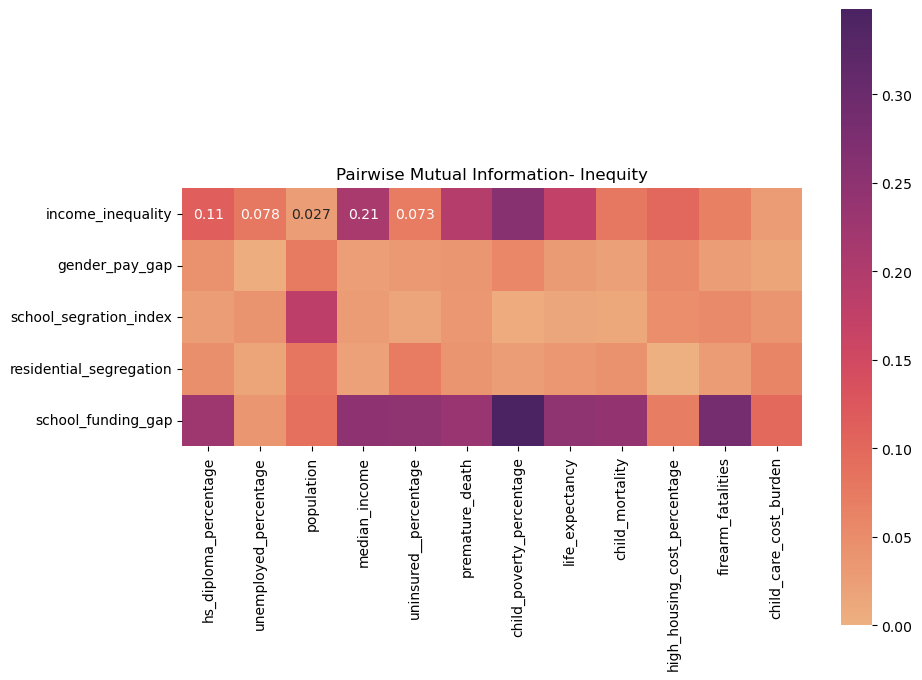

In [323]:
plt.figure(figsize=(10, 8))
sns.heatmap(mutual_info_df, annot=True, cmap='flare', square=True)
plt.title('Pairwise Mutual Information- Inequity')
plt.show()

#### Getting top values of dependent pairs

In [324]:
top_var_pairs = mutual_info_df.unstack().sort_values(ascending=False).head(12)
print(top_var_pairs)

child_poverty_percentage  school_funding_gap        0.348180
firearm_fatalities        school_funding_gap        0.286238
child_poverty_percentage  income_inequality         0.258842
median_income             school_funding_gap        0.249613
life_expectancy           school_funding_gap        0.248572
uninsured__percentage     school_funding_gap        0.246517
child_mortality           school_funding_gap        0.242587
premature_death           school_funding_gap        0.232733
hs_diploma_percentage     school_funding_gap        0.226168
median_income             income_inequality         0.209622
premature_death           income_inequality         0.192337
population                school_segration_index    0.181290
dtype: float64


### Selecting most 'infromative' variables
- x: 'school_funding_gap', 'income_inequality'
- y: 'child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death'

In [408]:
high_mutual_info_vars = ['state_abbr', 'county', 'fips', 'school_funding_gap', 'child_poverty_percentage', 'income_inequality', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death', 'political_party']
agg_select_subset = counties_pol_raw[high_mutual_info_vars]
x_vars= ['school_funding_gap', 'income_inequality'],
y_vars= ['child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death']

## Correlation and Covariance

<Axes: >

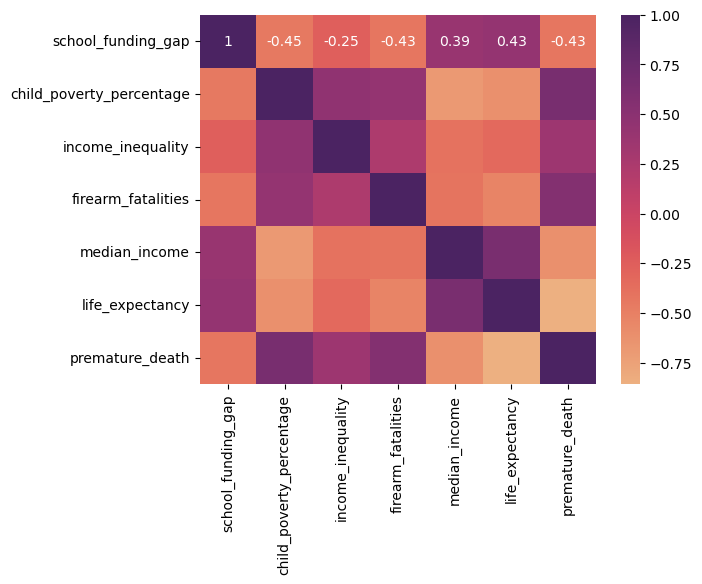

In [326]:
corr_matrix = agg_select_subset.corr(method='kendall', numeric_only=True).round(2)
sns.heatmap(corr_matrix, annot=True, cmap='flare')

### Correlations between selected explainer and selected outcome variables

In [327]:
print(agg_select_subset[y_vars].corrwith(agg_select_subset['school_funding_gap']))

child_poverty_percentage   -0.637112
firearm_fatalities         -0.604100
median_income               0.496392
life_expectancy             0.564720
premature_death            -0.579993
dtype: float64


In [328]:
print(agg_select_subset[y_vars].corrwith(agg_select_subset['income_inequality']))

child_poverty_percentage    0.622599
firearm_fatalities          0.366110
median_income              -0.503023
life_expectancy            -0.458570
premature_death             0.512731
dtype: float64


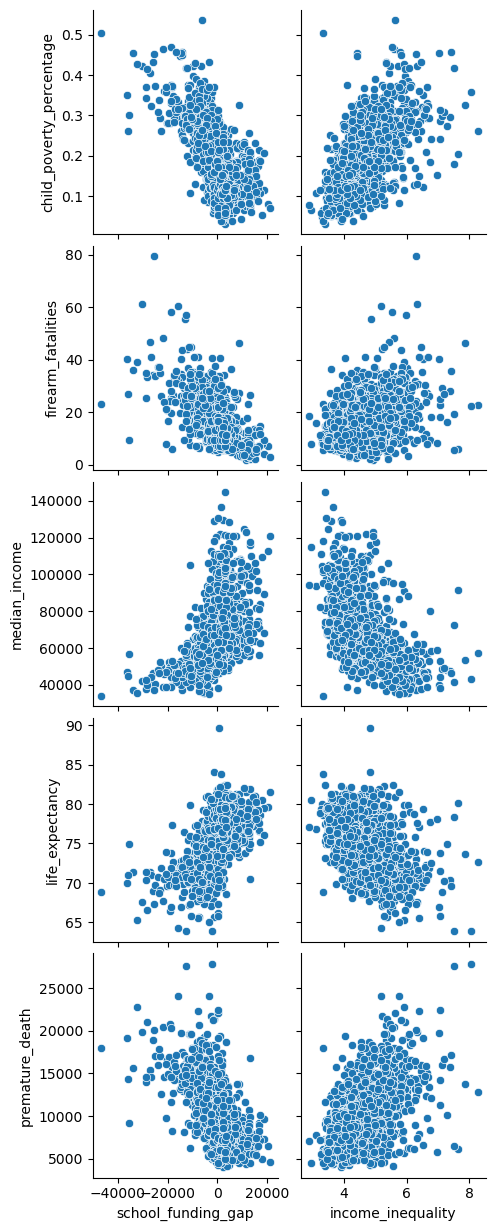

In [329]:
sns.pairplot(agg_select_subset, 
    x_vars= ['school_funding_gap', 'income_inequality'],
    y_vars= ['child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death'],
    )     

## Distributions

In [ ]:
agg_select_subset.hist(figsize=(12,12), layout=(3,3), color='teal', ec='black', sharex=False);

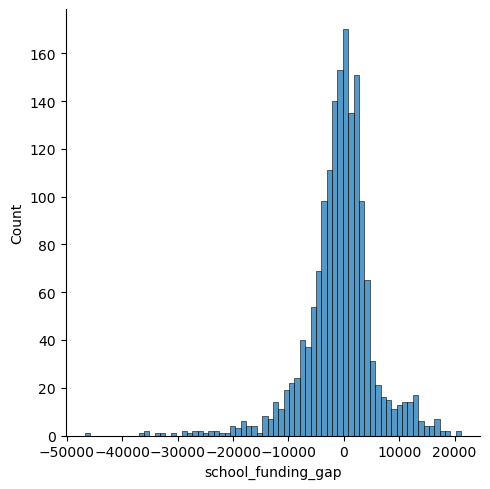

In [383]:
sns.displot(agg_select_subset['school_funding_gap'])

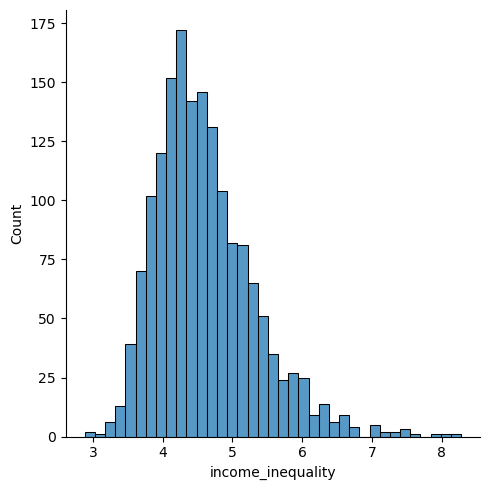

In [384]:
sns.displot(agg_select_subset['income_inequality'])

**Note**: not normally distributed

## Variation in each variable

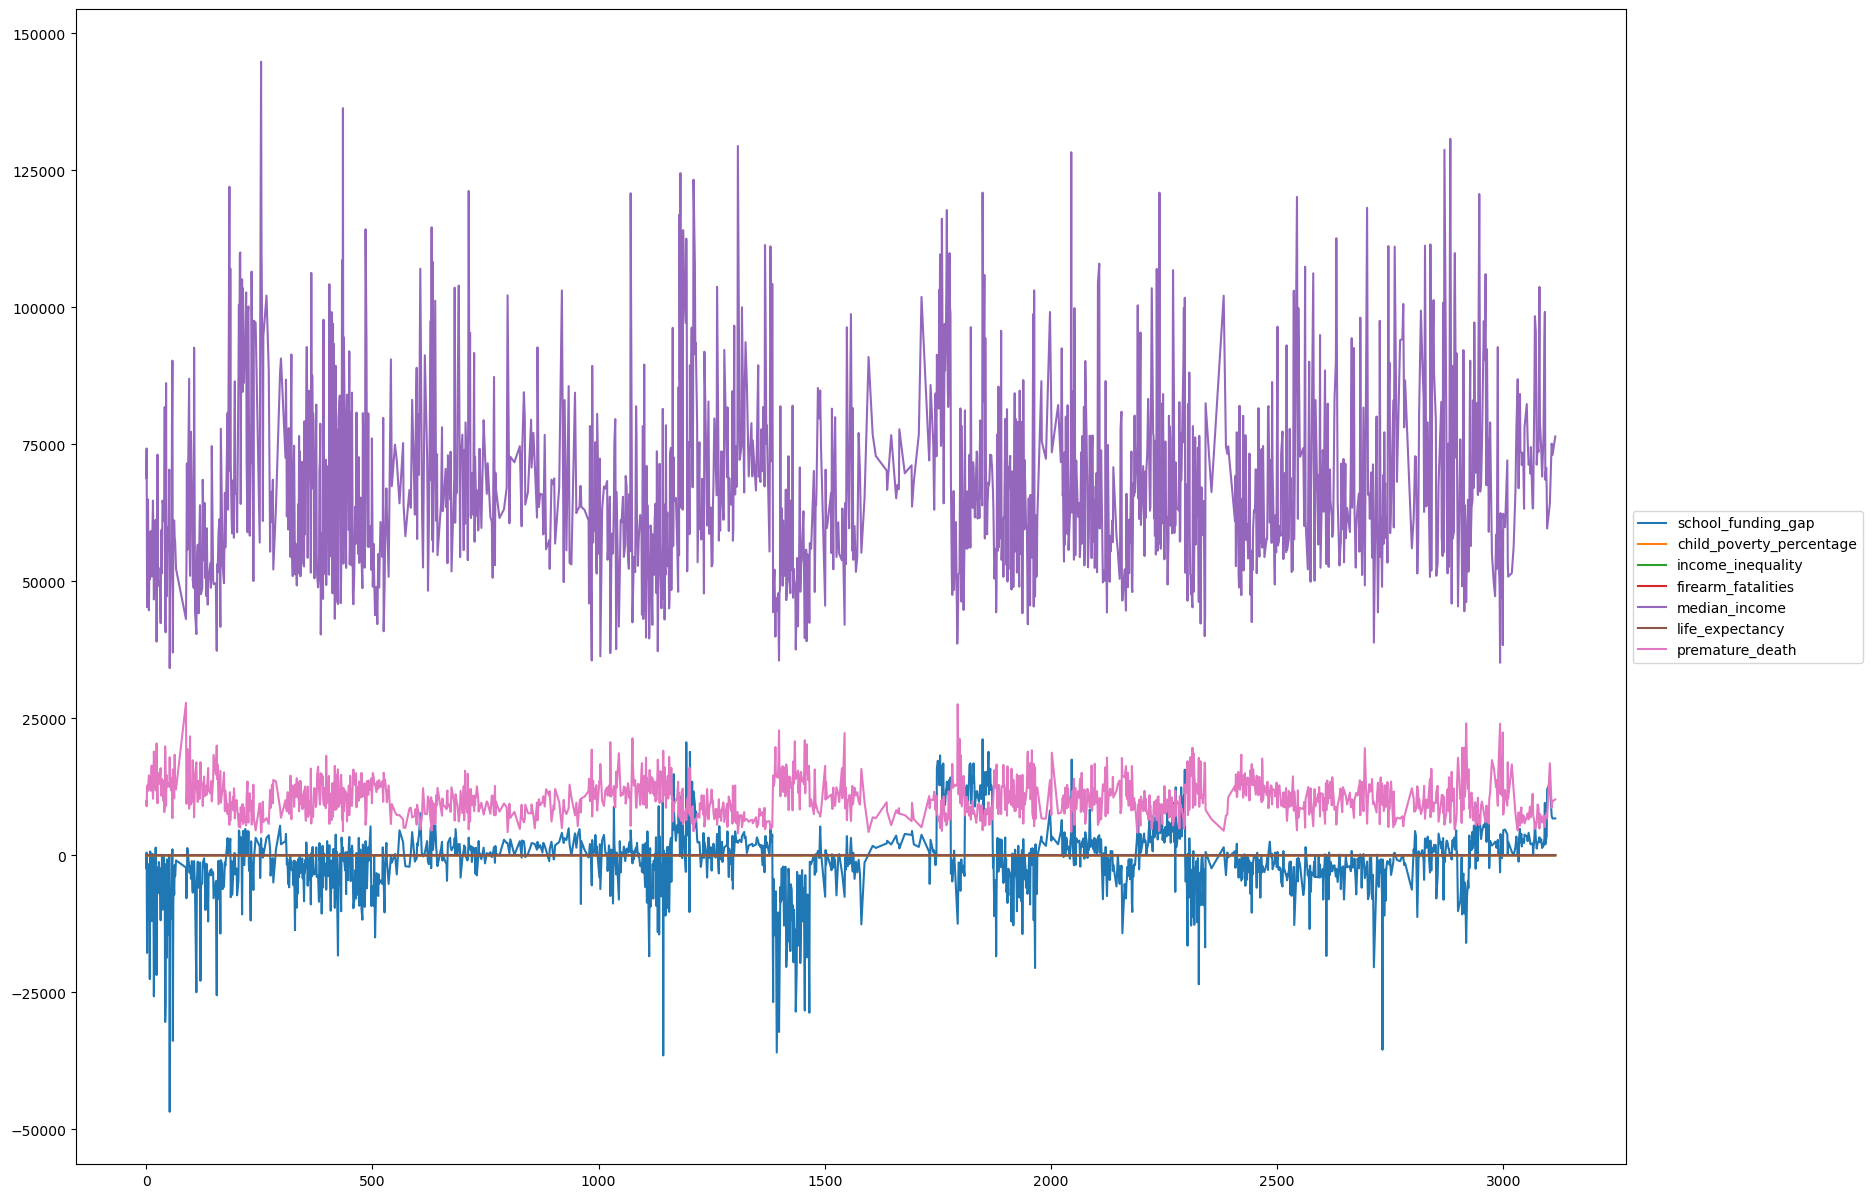

In [398]:
ax = agg_select_subset[high_mutual_info_vars].plot(figsize=(20,15))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

## Drill down on race

In [ ]:
all_sets_raw = all_sets.dropna()
all_sets_raw.reset_index(inplace=True)

In [409]:
#high_mutual_info_vars.remove('race')
race_high_val_mutual_info_vars = high_mutual_info_vars.copy()
race_high_val_mutual_info_vars.append('race')
race_select_subset = all_sets_raw[race_high_val_mutual_info_vars]

### Pair Plots

In [ ]:
sns.barplot(race_select_subset, x='race', y='premature_death')

In [374]:
race_select_subset.groupby('race')['child_poverty_percentage'].median()

race
aian        0.2970
black       0.3455
hispanic    0.2170
white       0.1190
Name: child_poverty_percentage, dtype: float64

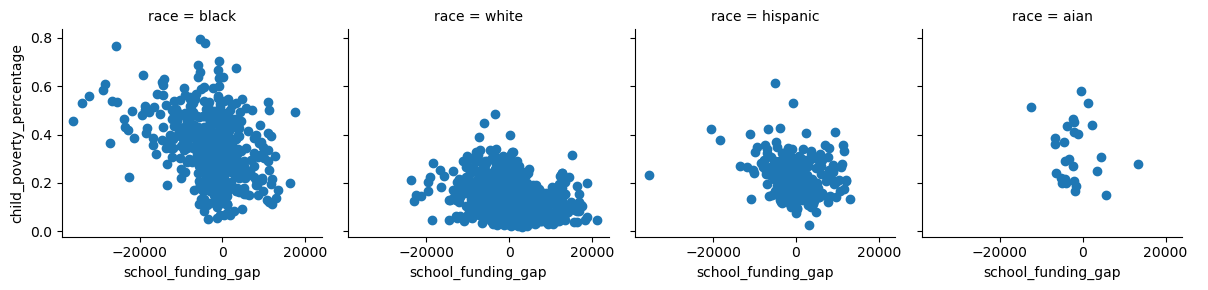

In [396]:
sns.FacetGrid(data = race_select_subset, col = 'race').map(plt.scatter, 'school_funding_gap', 'child_poverty_percentage').add_legend()
plt.show()

In [403]:
race_select_subset.columns

Index(['state_abbr', 'county', 'fips', 'school_funding_gap',
       'child_poverty_percentage', 'income_inequality', 'firearm_fatalities',
       'median_income', 'life_expectancy', 'premature_death', 'race'],
      dtype='object')

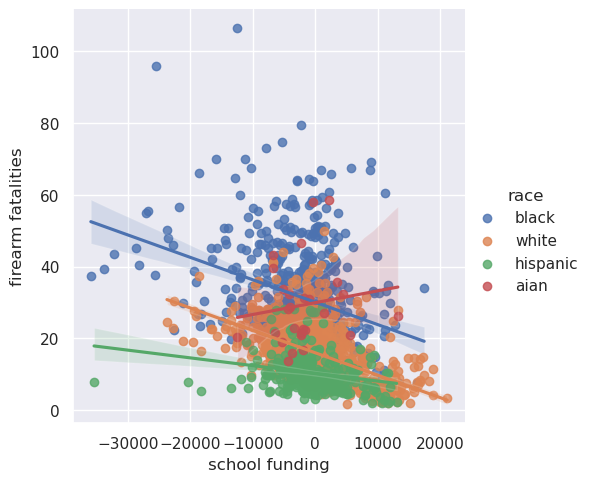

In [405]:
sns.set_theme()

g = sns.lmplot(
    data=race_select_subset,
    x='school_funding_gap', y='firearm_fatalities', hue='race',
    height=5
)

g.set_axis_labels('school funding', 'firearm fatalities')

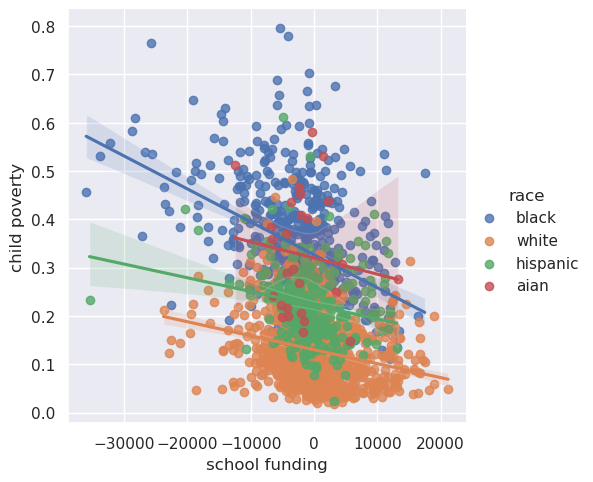

In [ ]:
sns.set_theme()

g = sns.lmplot(
    data=race_select_subset,
    x='school_funding_gap', y='child_poverty_percentage', hue='race',
    height=5
)

g.set_axis_labels('school funding', 'child poverty')

## Comparing distributions between inequality metric quantiles

In [381]:
q1_school_funding = agg_select_subset['school_funding_gap'].quantile(.25)
q2_school_funding = agg_select_subset['school_funding_gap'].quantile(.5)
q3_school_funding = agg_select_subset['school_funding_gap'].quantile(.75)

In [ ]:
q1_income_inequality = agg_select_subset.groupby('county')['income_inequality'].quantile(.25)
q2_income_inequality = agg_select_subset.groupby('county')['income_inequality'].quantile(.5)
q3_income_inequality = agg_select_subset.groupby('county')['income_inequality'].quantile(.75)

## Political Party

In [410]:
agg_select_subset.columns

Index(['state_abbr', 'county', 'fips', 'school_funding_gap',
       'child_poverty_percentage', 'income_inequality', 'firearm_fatalities',
       'median_income', 'life_expectancy', 'premature_death',
       'political_party'],
      dtype='object')

## Regression

In [ ]:
X = agg_select_subset[['school_funding_gap', 'income_inequality']]
y = agg_select_subset[['premature_death']]
X_train, X_test,\
  y_train, y_test = train_test_split(X, y,
                    test_size=0.4,
                    random_state=1)
reg = linear_model.LinearRegression()
model1 = reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

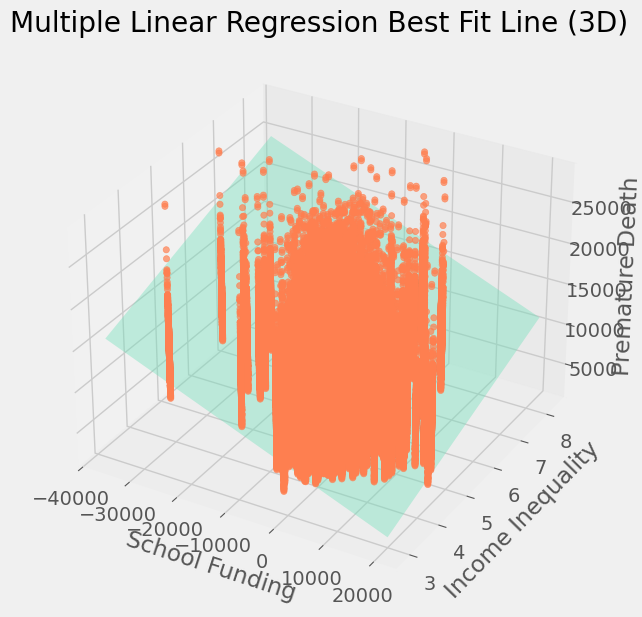

In [495]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_test['school_funding_gap'], X_test['income_inequality'],
           y_test, color='coral', alpha=0.7, label='Premature Death')

x1_range = np.linspace(X_test['school_funding_gap'].min(), X_test['school_funding_gap'].max(), 100)
x2_range = np.linspace(X_test['income_inequality'].min(), X_test['income_inequality'].max(), 100)
x1, x2 = np.meshgrid(x1_range, x2_range)

z = model.predict(np.c_[x1.ravel(), x2.ravel()]).reshape(x1.shape)

ax.plot_surface(x1, x2, z, color='aquamarine', alpha=0.4, rstride=100, cstride=100)

ax.set_xlabel('School Funding')
ax.set_ylabel('Income Inequality')
ax.set_zlabel('Premature Death')
ax.set_title('Multiple Linear Regression Best Fit Line (3D)')

plt.show()

In [480]:
# regression coefficients
print('Coefficients: ', reg.coef_)

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(X_test, y_test)))

Coefficients:  [[-5.58850500e-06  5.25766853e-02]
 [-5.82404896e-04  2.41439910e+00]
 [ 9.64399105e-01 -8.96690499e+03]
 [ 2.29999735e-04 -1.43192150e+00]
 [-2.32054184e-01  1.72685222e+03]]
Variance score: 0.43159922899967407


### Residual Errors

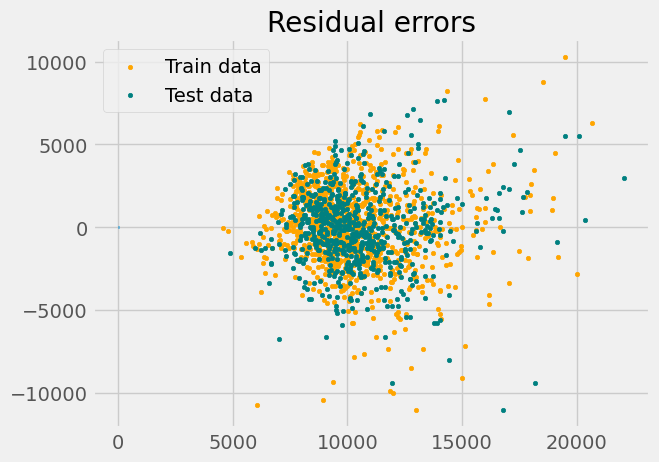

In [490]:
# plot for residual error

# setting plot style
plt.style.use('fivethirtyeight')

# plotting residual errors in training data
plt.scatter(reg.predict(X_train),
            reg.predict(X_train) - y_train,
            color="orange", s=10,
            label='Train data')

# plotting residual errors in test data
plt.scatter(reg.predict(X_test),
            reg.predict(X_test) - y_test,
            color="teal", s=10,
            label='Test data')

# plotting line for zero residual error
plt.hlines(y=0, xmin=0, xmax=50, linewidth=2)

# plotting legend
plt.legend(loc='upper left')

# plot title
plt.title("Residual errors")

# method call for showing the plot
plt.show()

In [ ]:
#regr = linear_model.LinearRegression()  
#model1= regr.fit(X, Y)

In [ ]:
#r2 = regr.score(X,Y)
#coefficients =regr.coef_
#intercept = regr.intercept_